Imports...

In [1]:
from ete3 import Tree, TreeStyle, NodeStyle
import numpy as np
from data import *
from phylo import *
from scipy.linalg import expm
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns
from random import seed
%matplotlib inline

Parameters...

In [2]:
random_seed = 1
np.random.seed(random_seed)
seed(random_seed)
number_of_taxa = 400
sequence_length = 1000
pired = np.array([.1, .2, .3, .4])
piblue = np.array([.4, .3, .2, .1])

Create a tree with red/blue edges for different substitution matrices...

Total distance: 204.0, chosen error: 17.4


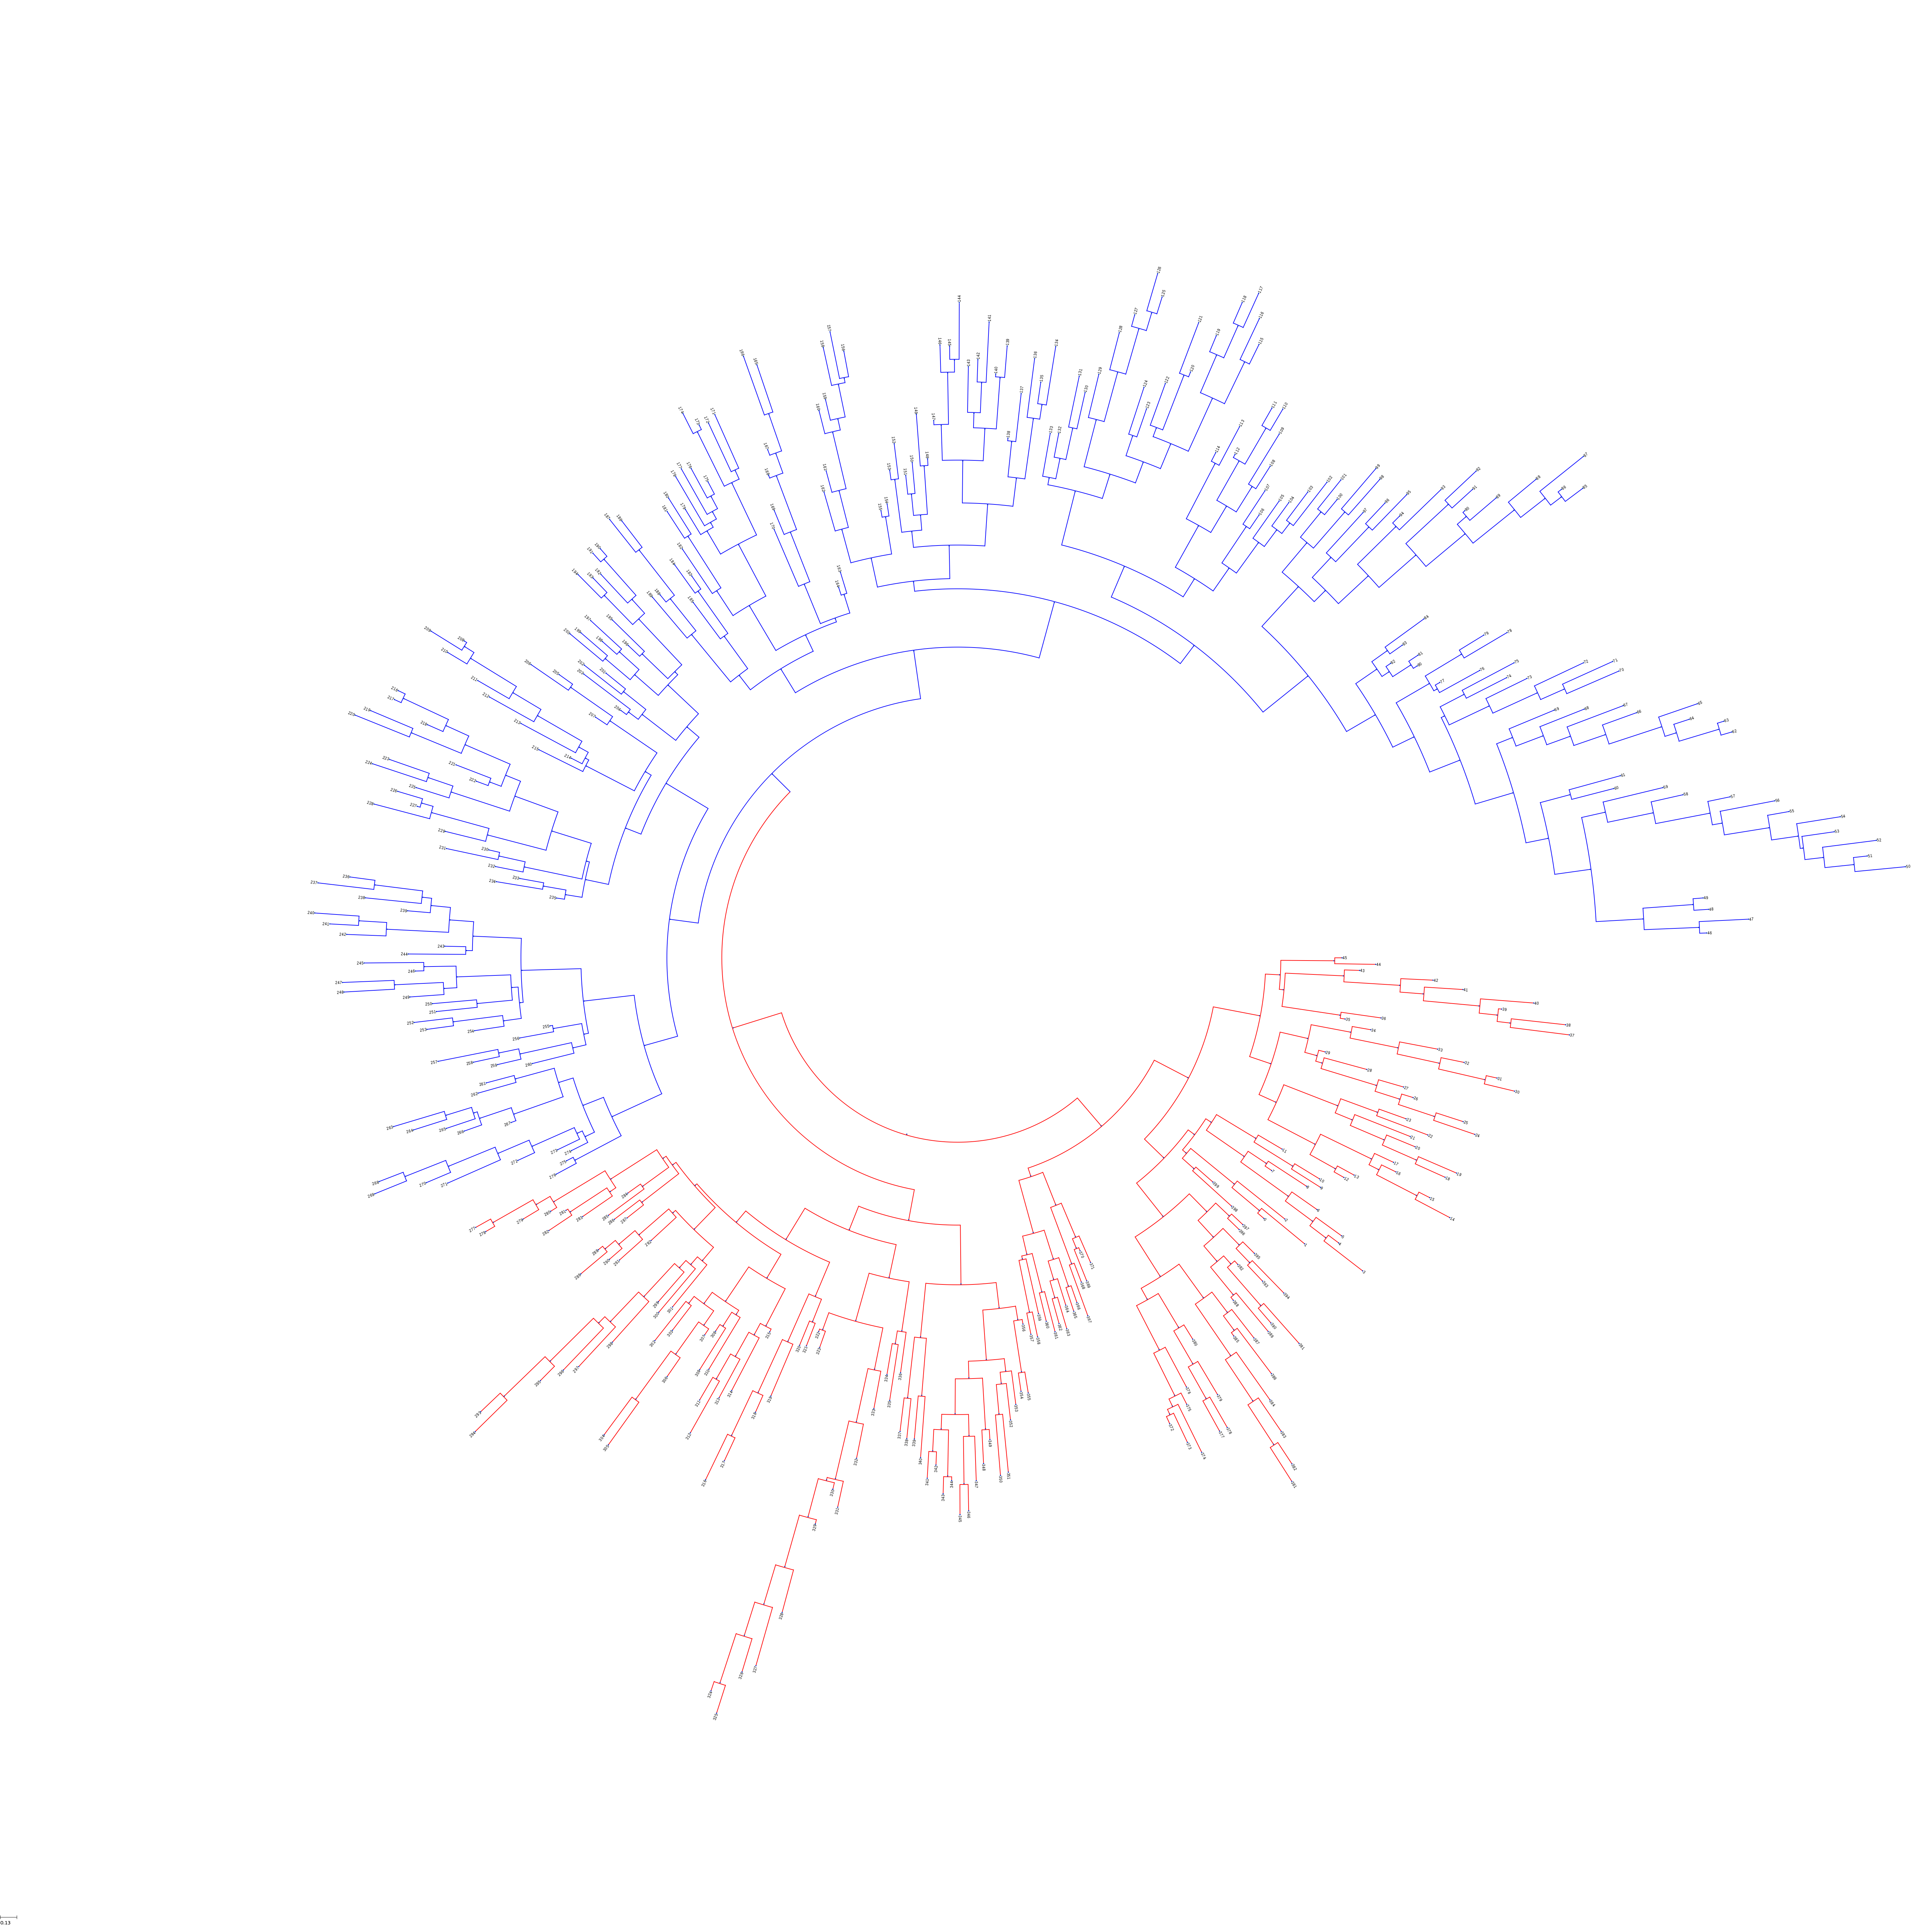

In [3]:
tree = Tree()
names_as_strings = [str(i) for i in range(number_of_taxa)]
tree.populate(number_of_taxa,
              random_branches=True,
              branch_range=(.01, .5),
              names_library=names_as_strings)
current_name = 2*number_of_taxa-2
for node in tree.traverse('preorder'):
    if not node.is_leaf():
        node.name = str(current_name)
        current_name -= 1
tree.dist = 0

tree_style = TreeStyle()
tree_style.mode = 'c'

red_style = NodeStyle()
red_style["hz_line_color"] = "#ff0000"
red_style["hz_line_width"] = 2
red_style["vt_line_color"] = "#ff0000"
red_style["vt_line_width"] = 2

blue_style = NodeStyle()
blue_style["hz_line_color"] = "#0000ff"
blue_style["hz_line_width"] = 2
blue_style["vt_line_color"] = "#0000ff"
blue_style["vt_line_width"] = 2

total_distance = 0
for node in tree.traverse('preorder'):
    total_distance += node.dist
closest_distance = total_distance
for node in tree.traverse('postorder'):
    if node.is_leaf():
        node.cumulative_distance = 0
    else:
        children = node.get_children()
        child_distance = [child.dist for child in children]
        child_cumulative_distances = [child.cumulative_distance for child in children]
        node.cumulative_distance = sum(child_distance)+sum(child_cumulative_distances)
        
        current_distance = abs(node.cumulative_distance-total_distance/2)
        if current_distance < closest_distance:
            closest_distance = current_distance
            chosen_node = node

for node in tree.traverse('preorder'):
    node.set_style(red_style)
    node.type = 'red'
for node in chosen_node.traverse('preorder'):
    node.set_style(blue_style)
    node.type = 'blue'

print('Total distance: %.1f, chosen error: %.1f' % (total_distance, closest_distance))
tree.render('%%inline', tree_style=tree_style)

Create data and make inference. This requires modifying <code>generate_data</code>, <code>L0</code> and <code>prune</code> to look at the correct parameters for a given branch/node.

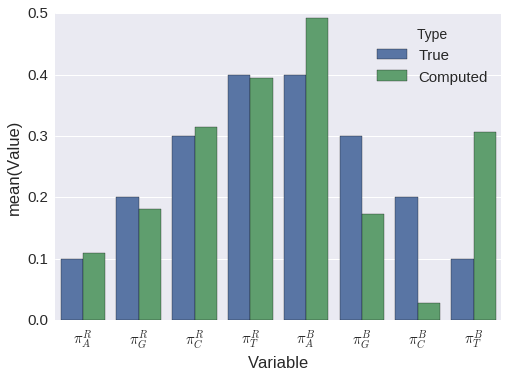

In [4]:
initial_sequence = random_sequence(sequence_length, pired)

def generate_data(initial_sequence, Qred, Qblue, tree):
    extant_taxa = len(tree.get_leaves())
    sequence_length = len(initial_sequence)
    data = np.empty((2*extant_taxa-1, sequence_length), dtype=np.int)
    for node in tree.traverse('preorder'):
        index = int(node.name)
        if node.is_root():
            data[index, :] = initial_sequence
        else:
            if node.type == 'red':
                Q = Qred
            else:
                Q = Qblue
            parent_index = int(node.up.name)
            parent_sequence = data[parent_index, :]
            l = node.dist
            new_sequence = mutate_sequence(parent_sequence, Q, l)
            data[index, :] = new_sequence
    return data

Qred = f81(pired)
Qblue = f81(piblue)
data = generate_data(initial_sequence, Qred, Qblue, tree)

def L0(data, tree, pi):
    pired = pi[:4]
    piblue = pi[4:]
    Qred = f81(pired)
    Qblue = f81(piblue)
    extant_taxa = data.shape[0]
    sequence_length = data.shape[1]
    u = 4
    L = np.zeros((u, sequence_length, 2*extant_taxa-1))
    all_sequence_indices = np.arange(sequence_length)
    for node in tree.traverse('postorder'):
        index = int(node.name)
        sequence = data[index, :]
        if node.is_leaf():
            L[sequence, all_sequence_indices, index] = 1
        else:
            left_child, right_child = node.children
            left_index = int(left_child.name)
            right_index = int(right_child.name)
            L_left = L[:, :, left_index]
            L_right = L[:, :, right_index]
            t_left = left_child.dist
            t_right = right_child.dist
            try:
                if left_child.type == 'red':
                    P_left = expm(t_left*Qred)
                else:
                    P_left = expm(t_left*Qblue)
                if right_child.type == 'red':
                    P_right = expm(t_right*Qred)
                else:
                    P_right = expm(t_right*Qblue)
            except ValueError:
                raise Exception('Could not compute matrix exponentials!')
            L[:, :, index] = np.dot(P_left, L_left) * np.dot(P_right, L_right)
        if node.is_root():
            return L[:,:,0]


def prune(data, tree, pi):
    pired = pi[:4]
    L = L0(data, tree, pi)
    u = 4
    l0 = np.dot(pired.reshape(1, u), L)
    return np.sum(np.log(l0))
    
pi0 = np.random.rand(8)
pi0[:4] /= np.sum(pi0[:4])
pi0[4:] /= np.sum(pi0[4:])
sumtoone1 = lambda pi: np.sum(pi[:4])-1
sumtoone2 = lambda pi: np.sum(pi[4:])-1
constraints = [{'type':'eq', 'fun':sumtoone1}, {'type':'eq', 'fun':sumtoone2}]
bounds = 8*((1e-6, 1), )
objective = lambda pi: -prune(data, tree, pi)
result = minimize(objective, pi0, constraints=constraints, bounds=bounds)

red_labels = ['$\pi^R_%s$' % nuc for nuc in nucleotides]
blue_labels = ['$\pi^B_%s$' % nuc for nuc in nucleotides]
labels = red_labels+blue_labels
df = pd.DataFrame({'Variable': 2*labels,
                   'Value': np.hstack([pired, piblue, result.x]),
                   'Type': 8*['True']+8*['Computed'] })
sns.set(font_scale=1.5)
sns.barplot(x='Variable', y='Value', data=df, hue='Type')